In [1]:
# ipython
%matplotlib inline

from IPython.display import display as d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
import glob
import json
import os
import sys
import json
import os
import sys
import multiprocessing
pool = multiprocessing.Pool(multiprocessing.cpu_count())


In [50]:
import sqlite3
conn = sqlite3.connect('ratings.db')

tables = ["info", "ratings", "user_playlist"]

df = pd.read_sql_query("SELECT * from ratings", conn)
dinfo = pd.read_sql_query("SELECT * from info", conn)
dpl = pd.read_sql_query("SELECT * from user_playlist", conn)


d(dinfo.head())
d(dpl.head())
d(df.head())

,user_ID,info_json
0,1,"{""userAgeRange"": ""30 to 39"", ""userGender"": ""Ma..."
1,4,"{""userAgeRange"": ""30 to 39"", ""userGender"": ""Ma..."
2,5,"{""userAgeRange"": ""25 to 29"", ""userGender"": ""Ma..."
3,6,"{""userAgeRange"": ""25 to 29"", ""userGender"": ""Ma..."
4,62,"{""userAgeRange"": ""25 to 29"", ""userGender"": ""Fe..."


,user_ID,playlist,timestamp
0,1,"[688, 309, 152, 1161, 1011, 1267, 757, 441, 11...",2020-03-27 13:50:53 566703
1,2,"[956, 589, 1082, 650, 657, 807, 596, 970, 1023...",2020-03-27 13:35:00 968899
2,3,"[468, 313, 1210, 1287, 996, 271, 1149, 439, 81...",2020-03-27 14:14:14 643751
3,4,"[476, 912, 42, 1258, 732, 308, 1155, 1079, 410...",2020-03-27 14:55:32 195248
4,5,"[358, 1385, 786, 777, 902, 644, 1002, 1183, 14...",2020-03-27 16:06:05 479548


,user_ID,stimuli_ID,stimuli_file,rating_type,rating,timestamp
0,1,-1,,user_registered,-1,2020-03-27 13:50:53 566942
1,1,688,./images/Sparks_20170214.mxf_1frame_crf_06_hei...,acr,2,2020-03-27 13:51:10 959845
2,1,309,./images/NTIA_4K_Vignette_1_Violin-422p-8bit-6...,acr,1,2020-03-27 13:51:14 468659
3,1,152,./images/classroom.mkv_1frame_crf_12_height_03...,acr,2,2020-03-27 13:51:18 371806
4,1,1161,./images/asian_fusion_harmonic.mkv_1frame_crf_...,acr,1,2020-03-27 13:51:21 653894


138


,browser_agent,screen_size,userAgeRange,userComputerType,userEyeQuality,userRoomQuality,os
0,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,722,30 to 39,Laptop,Good(4),Some Noise and Distractions,MacOS
1,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,722,30 to 39,Laptop,Excellent(5),Alone in a Quiet Room,Win
2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1298,25 to 29,Desktop,Excellent(5),Alone in a Quiet Room,Win
3,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,937,25 to 29,Desktop,Excellent(5),Alone in a Quiet Room,Win
4,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,722,25 to 29,Laptop,Good(4),Alone in a Quiet Room,Win


browser_agent
os
screen_size
userAgeRange
userComputerType
userEyeQuality
userRoomQuality


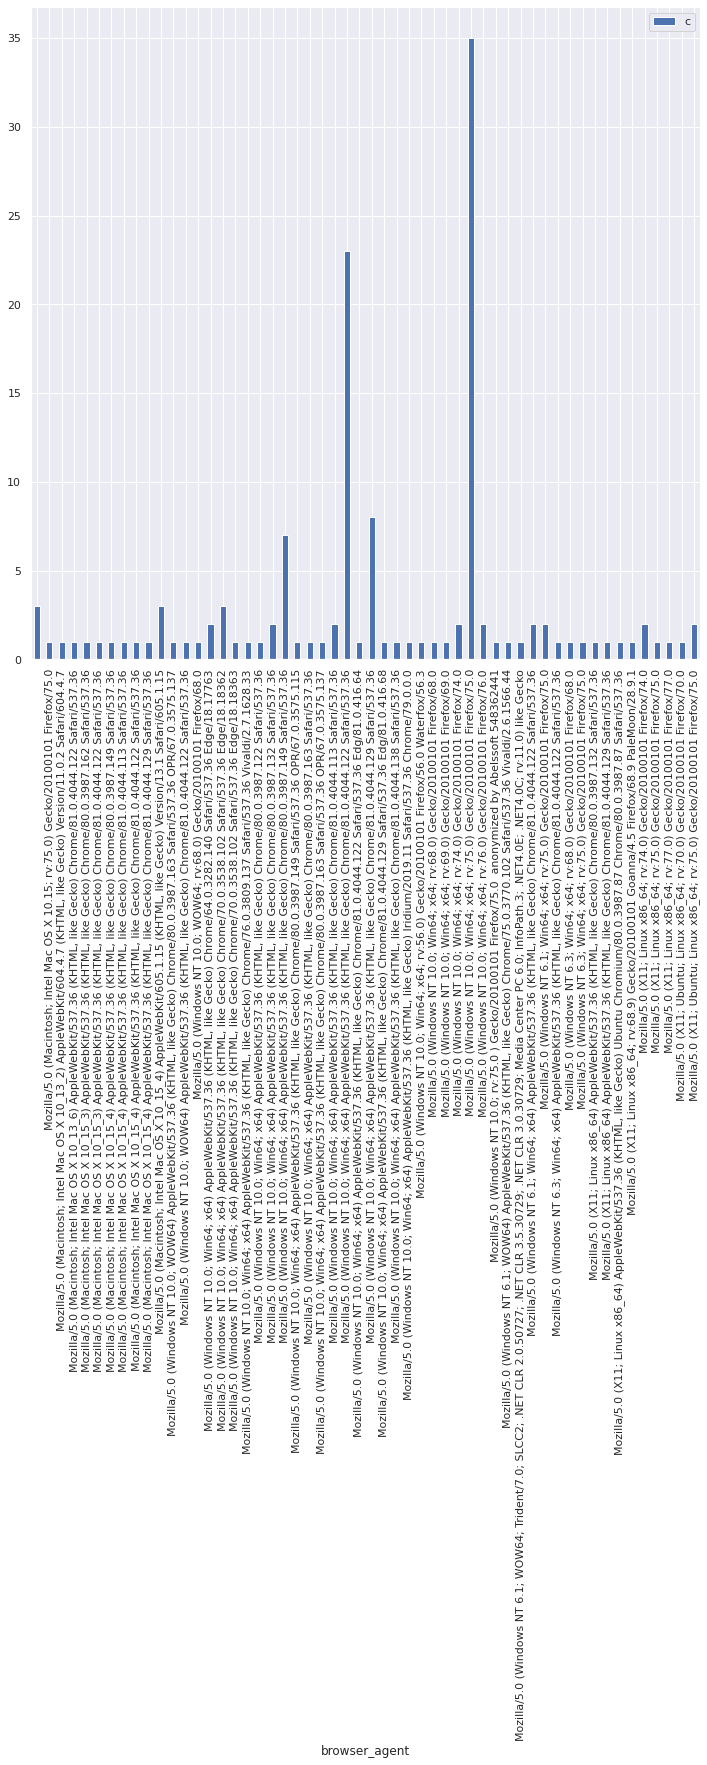

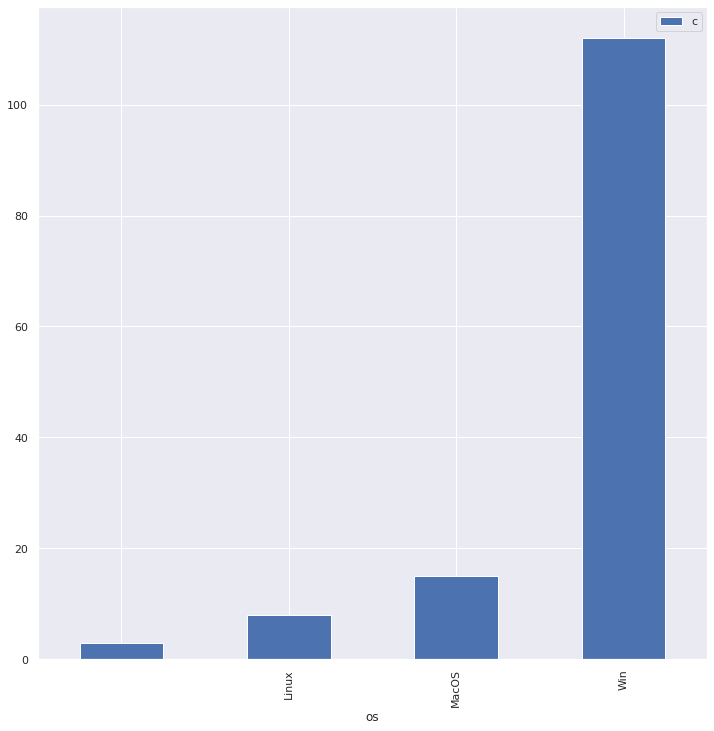

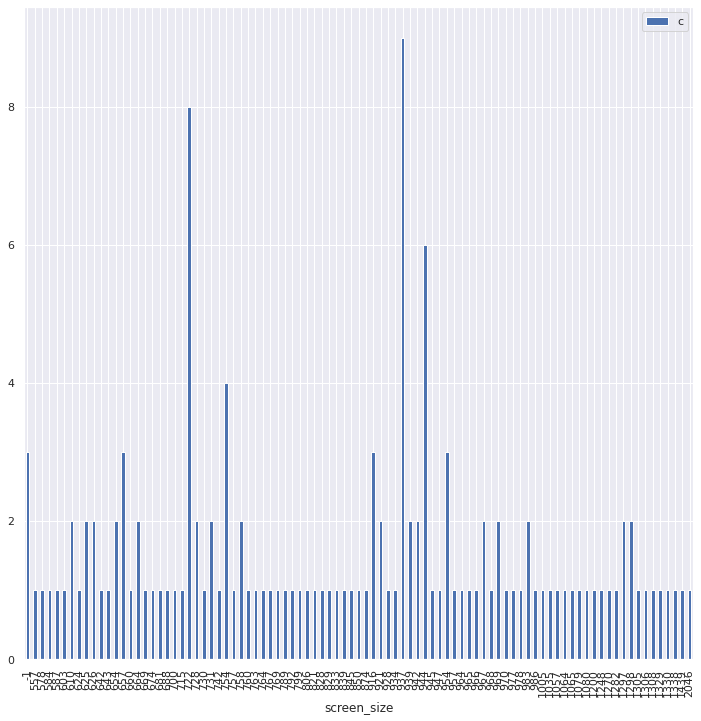

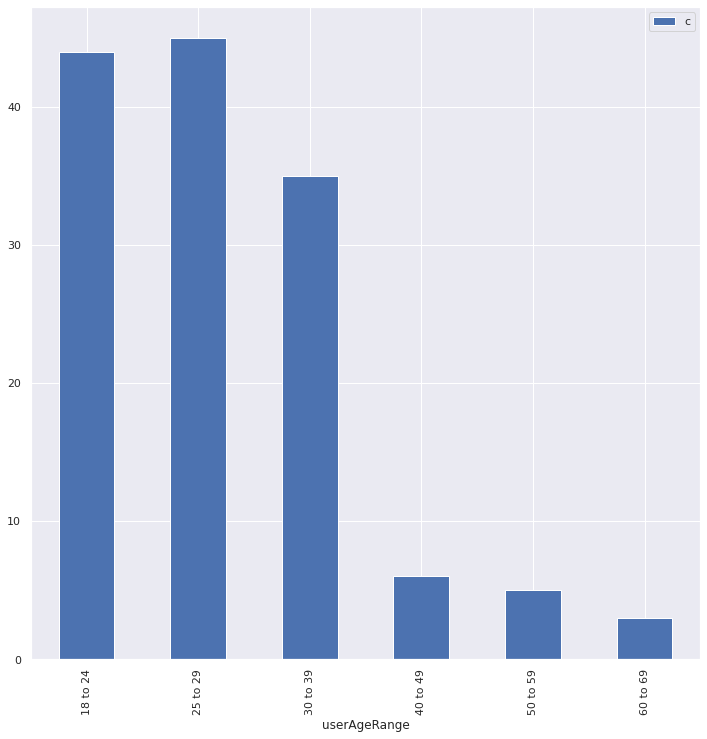

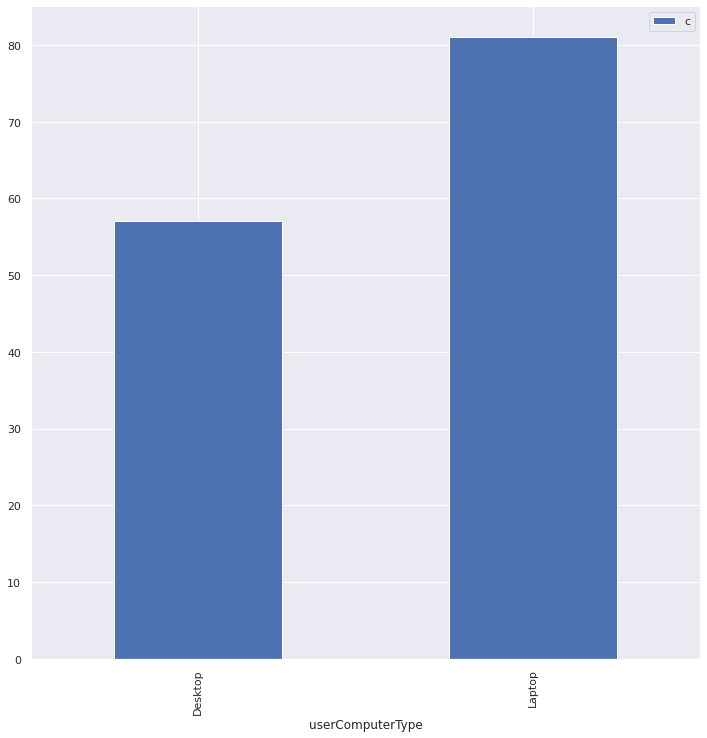

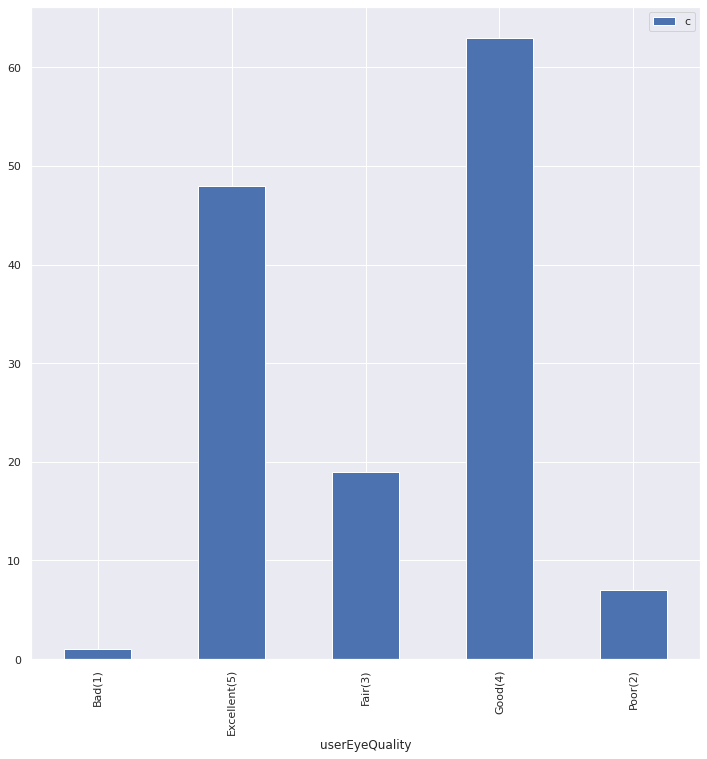

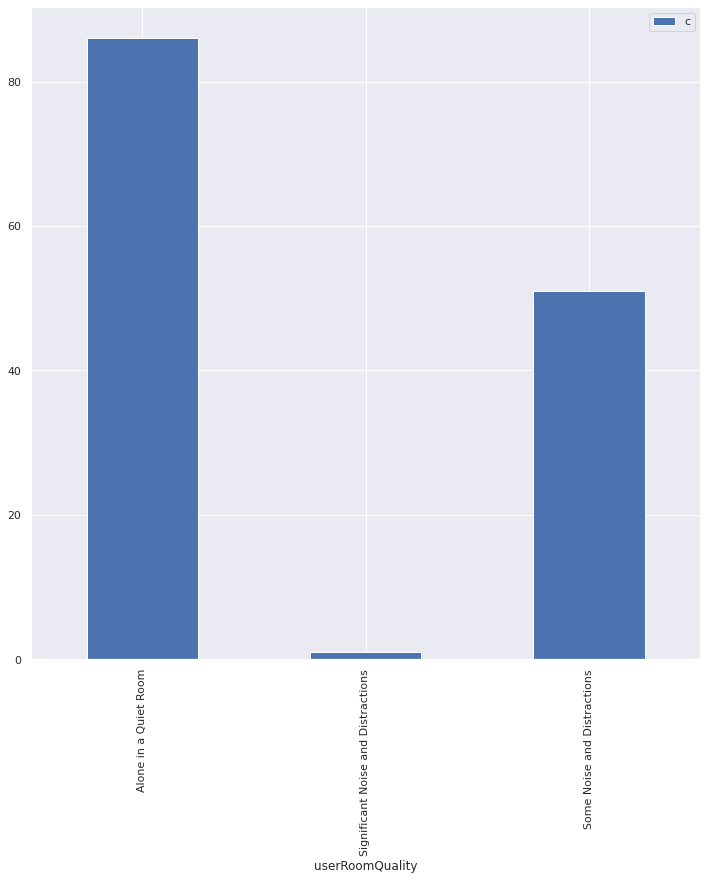

In [40]:
import matplotlib.pyplot as plt

def extract_info(x):
    return pd.Series(json.loads(x))
di = pd.DataFrame(dinfo["info_json"].apply(extract_info))
di = di[di.columns.difference(["userGender"])]

def estimate_os(x):
    if "Windows" in x:
        return "Win"
    if "Apple" in x or "Mac" in x:
        return "MacOS"
    if "Linux" in x:
        return "Linux"
    return x

di["os"] = di["browser_agent"].apply(estimate_os)

di["screen_size"] = di["screen_size"].apply(lambda x: -1 if x == "" else int(x.split("x")[1]))
print(len(di))
d(di.head())
di["c"] = 1
for c in di.columns.difference(["c"]):
    print(c)
    di.groupby(by=c).count().reset_index()[[c, "c"]].plot(x=c, y="c", kind="bar")

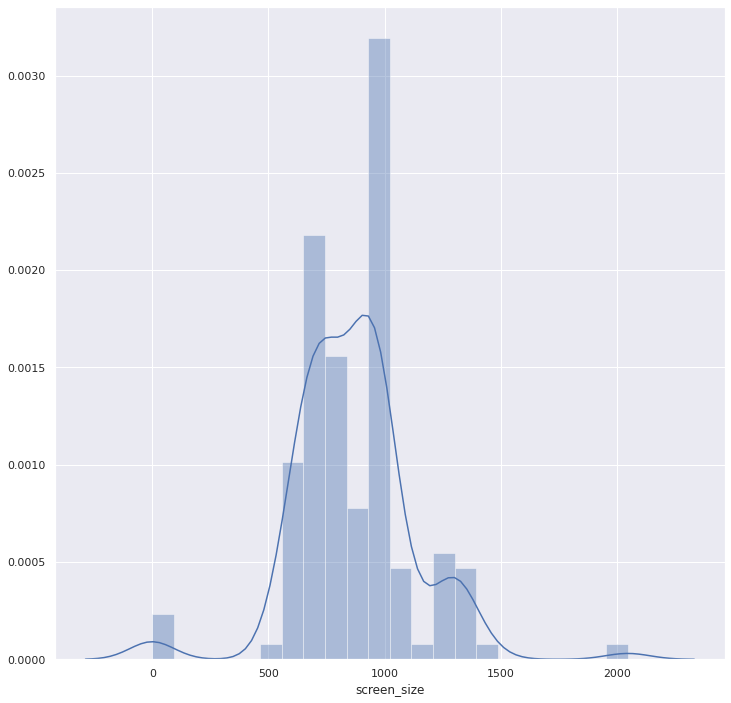

In [39]:
sns.distplot(di["screen_size"])

,user_ID,stimuli_ID,stimuli_file,rating_type,rating,timestamp
0,1,-1,,user_registered,-1,2020-03-27 13:50:53 566942
1,1,688,./images/Sparks_20170214.mxf_1frame_crf_06_hei...,acr,2,2020-03-27 13:51:10 959845
2,1,309,./images/NTIA_4K_Vignette_1_Violin-422p-8bit-6...,acr,1,2020-03-27 13:51:14 468659
3,1,152,./images/classroom.mkv_1frame_crf_12_height_03...,acr,2,2020-03-27 13:51:18 371806
4,1,1161,./images/asian_fusion_harmonic.mkv_1frame_crf_...,acr,1,2020-03-27 13:51:21 653894


14591 14248 343


<ipython-input-61-77fb36171f4e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr["c"] = 1


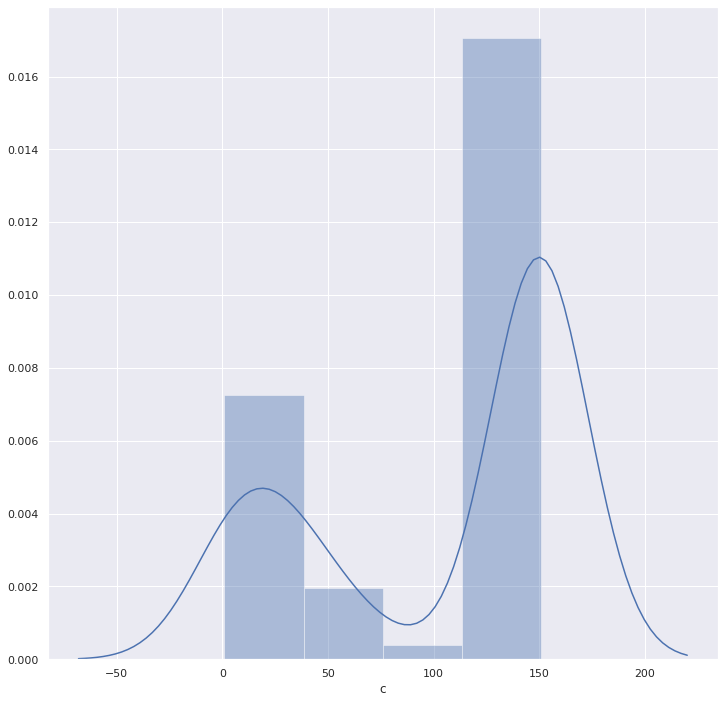

In [61]:
d(df.head())
df["rating"] = df["rating"].astype(np.int)
# select pure ratings
dr = df[df["rating"] > 0]
print(
    len(df),
    len(dr),
    len(df) - len(dr)
)

dr["c"] = 1
sns.distplot(dr.groupby(by="user_ID").count().reset_index()["c"])

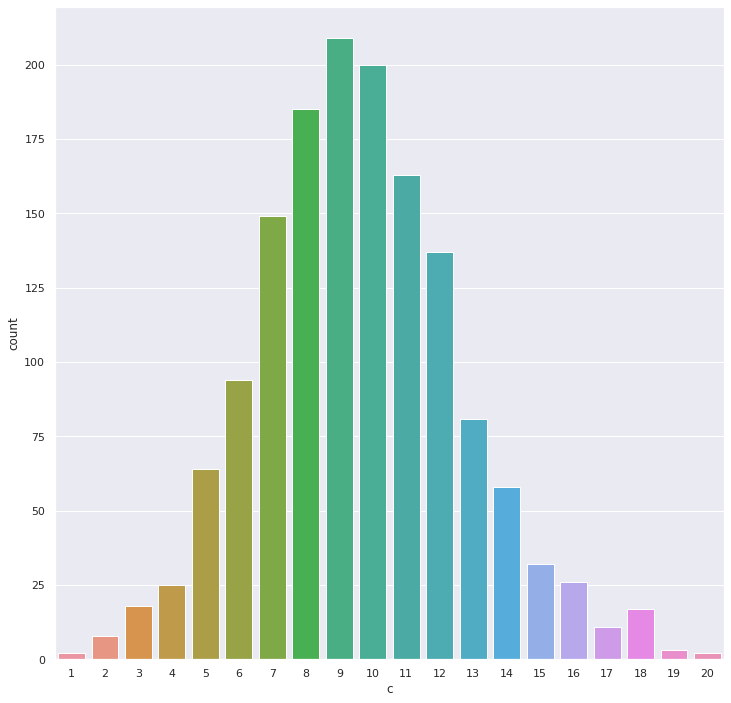

In [72]:
sns.countplot(dr.groupby(by=["stimuli_ID"]).count().reset_index()["c"])

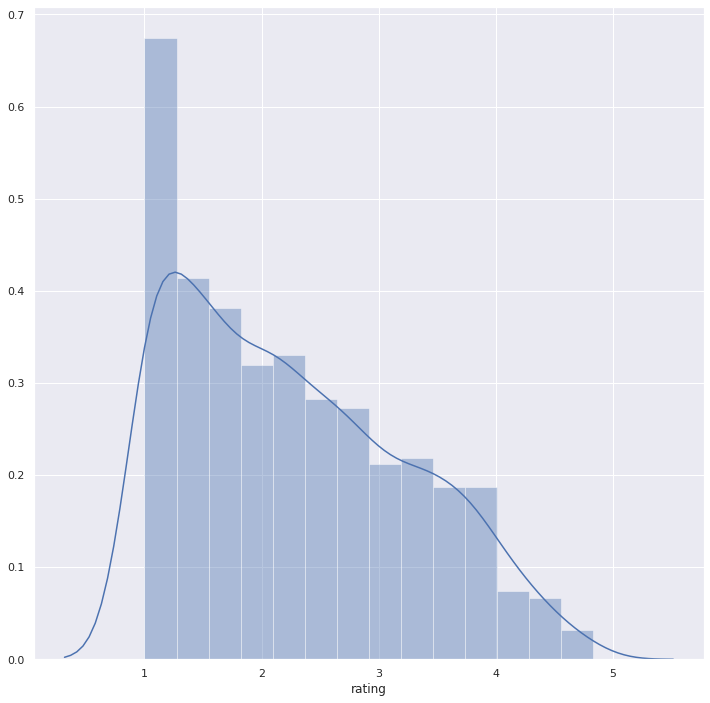

In [74]:
sns.distplot(dr.groupby(by=["stimuli_ID"]).mean().reset_index()["rating"])

In [124]:
dmos = pd.read_csv("../test_1/mos_ci.csv")
d(dmos.head())
print(len(dmos))
dr["image_name"] = dr["stimuli_file"].apply(lambda x: "_".join(os.path.basename(x).split("_")[0:-1])).copy()

dmean_r = dr.groupby(by="image_name").mean().reset_index()[["image_name", "rating"]]
dmean_r = dmean_r.rename(columns={"rating": "mean_crowd"})
print(len(dmean_r), len(dr))

d(dmean_r.head())

dmerged = pd.merge(dmos, dmean_r)
d(dmerged.head())

,image_name,mos,ci
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249


371
371 14248


<ipython-input-124-f262258dfb6e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr["image_name"] = dr["stimuli_file"].apply(lambda x: "_".join(os.path.basename(x).split("_")[0:-1])).copy()


,image_name,mean_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,2.911765
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.552632
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.432432
3,BennuProRes4444.mov_1frame_crf_13_height_0304,1.980000
4,BennuProRes4444.mov_1frame_crf_21_height_0320,1.642857


,image_name,mos,ci,mean_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,2.911765
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,2.552632
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,2.432432
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,1.980000
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,1.642857


0.96

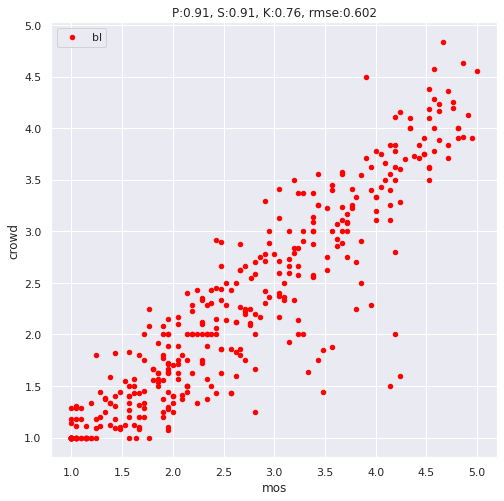

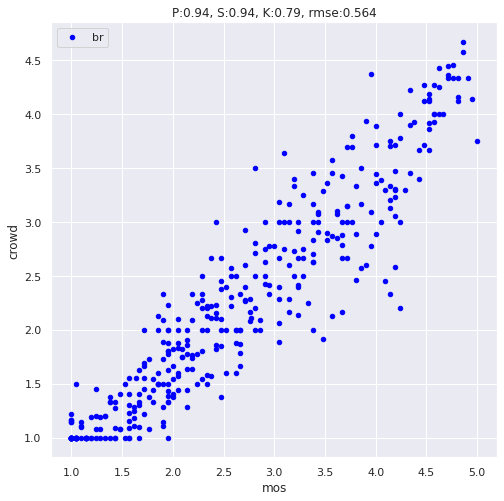

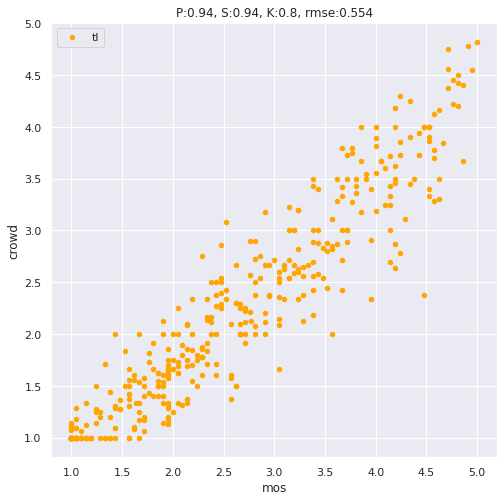

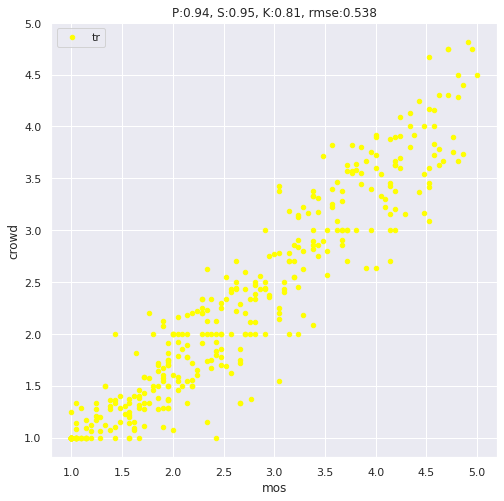

In [185]:
dr["patch"] = dr["stimuli_file"].apply(lambda x: x.split("_")[-1].split(".")[0])
dr = dr.rename(columns={
    "rating": "crowd"
})

#d(dr.head())
cmap = {
    "bl": "red", 
    "br": "blue", 
    "tl": "orange", 
    "tr": "yellow"
}
ax = None
vvv = []
for i, g in dr.groupby(by="patch"):
    dgg = pd.merge(g, dmos).groupby(by="image_name").mean()
    #print(i)
    #print(len(dgg))
    #d(dgg.head())
    rmse = ((dgg["mos"] - dgg["crowd"]) ** 2).mean() ** .5 
    corr = "P:{}, S:{}, K:{}, rmse:{}".format(
        dgg[["mos", "crowd"]].corr(method="pearson")["mos"][1].round(2),
        dgg[["mos", "crowd"]].corr(method="spearman")["mos"][1].round(2),
        dgg[["mos", "crowd"]].corr(method="kendall")["mos"][1].round(2),
        rmse.round(3)
    )

    ax = dgg.plot(x="mos", y="crowd", kind="scatter", figsize=(8,8), title=corr, c=cmap[i], label=i)
    vvv.append(dgg.copy())
    #break

d(((vvv[-2] + vvv[-1])/ 2)[["mos", "crowd"]].corr(method="pearson")["mos"][1].round(2))

,image_name,std_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,0.965076
1,BennuProRes4444.mov_1frame_crf_06_height_0592,0.724004
2,BennuProRes4444.mov_1frame_crf_08_height_0448,0.834684
3,BennuProRes4444.mov_1frame_crf_13_height_0304,0.769044
4,BennuProRes4444.mov_1frame_crf_21_height_0320,0.621485


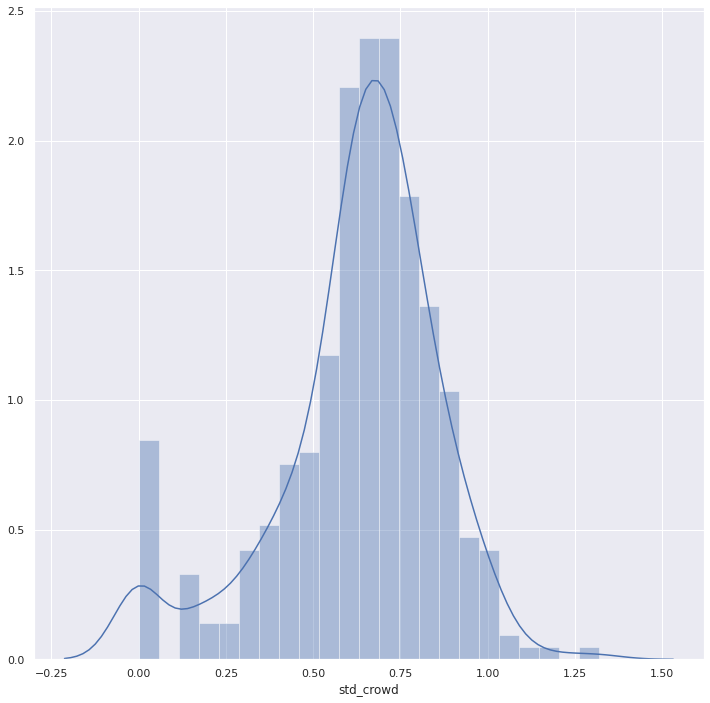

In [160]:
dvar_r = dr.groupby(by="image_name").std().reset_index()[["image_name", "rating"]]
dvar_r = dvar_r.rename(columns={"rating": "std_crowd"})
d(dvar_r.head())

sns.distplot(dvar_r["std_crowd"])

,stimuli_file,std_crowd_per_patch
0,./images/BennuProRes4444.mov_1frame_crf_03_hei...,1.048809
1,./images/BennuProRes4444.mov_1frame_crf_03_hei...,0.674200
2,./images/BennuProRes4444.mov_1frame_crf_03_hei...,1.000000
3,./images/BennuProRes4444.mov_1frame_crf_03_hei...,0.755929
4,./images/BennuProRes4444.mov_1frame_crf_06_hei...,0.514929


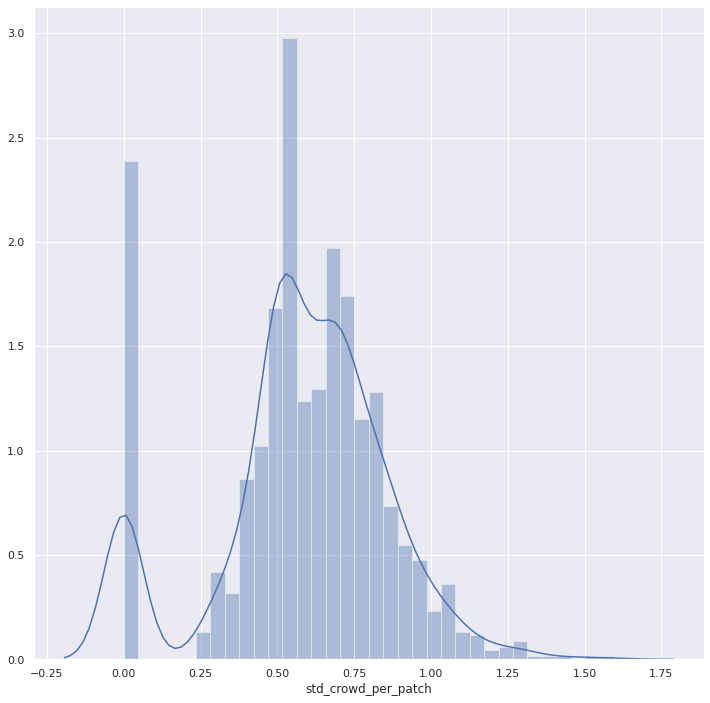

In [161]:


dvar_r_pp = dr.groupby(by="stimuli_file").std().reset_index()[["stimuli_file", "rating"]]
dvar_r_pp = dvar_r_pp.rename(columns={"rating": "std_crowd_per_patch"})
d(dvar_r_pp.head())

sns.distplot(dvar_r_pp["std_crowd_per_patch"])

In [136]:
v = []
for i,g in dr.groupby(by="image_name"):
    #print(i)
    at_least_24 = 1
    at_least_12 = 1
    at_least_10 = 1
    at_least_5 = 1
    k = 0
    patch_count = {}
    for j, gg in g.groupby(by="stimuli_file"):
        #d(gg)
        patch_count[j.split("_")[-1].split(".")[0]] = len(gg)
        if len(gg) < 24:
            at_least_24 = 0
        
        if len(gg) < 12:
            at_least_12 = 0
        if len(gg) < 10:
            at_least_10 = 0
            
        if len(gg) < 5:
            at_least_5 = 0
        k += 1
    v.append(dict({
        "image": i, 
        "at_least_24": at_least_24, 
        "at_least_12": at_least_12, 
        "at_least_10": at_least_10, 
        "at_least_5": at_least_5, 
        "k": k
    }, **patch_count))


In [139]:
dv = pd.DataFrame(v)
d(dv.head())
d(dv[dv["at_least_24"] == 1])
d(dv[dv["at_least_12"] == 1])
d(dv[dv["at_least_10"] == 1])

print(

dv["at_least_10"].sum(),
    
dv["at_least_5"].sum()
)

,image,at_least_24,at_least_12,at_least_10,at_least_5,k,bl,br,tl,tr
0,BennuProRes4444.mov_1frame_crf_03_height_0864,0,0,0,1,4,6,11,9,8
1,BennuProRes4444.mov_1frame_crf_06_height_0592,0,0,0,1,4,12,8,9,9
2,BennuProRes4444.mov_1frame_crf_08_height_0448,0,0,0,0,4,8,2,12,15
3,BennuProRes4444.mov_1frame_crf_13_height_0304,0,0,0,1,4,14,8,18,10
4,BennuProRes4444.mov_1frame_crf_21_height_0320,0,0,0,0,4,10,9,8,1


,image,at_least_24,at_least_12,at_least_10,at_least_5,k,bl,br,tl,tr


,image,at_least_24,at_least_12,at_least_10,at_least_5,k,bl,br,tl,tr
102,Netflix_DinnerScene_4096x2160_60fps_10bit_420....,0,1,1,1,4,12,13,12,18


,image,at_least_24,at_least_12,at_least_10,at_least_5,k,bl,br,tl,tr
20,Campfire_3840x2160_30fps_bt709_420_videoRange_...,0,0,1,1,4,11,12,10,11
39,CatRobot_3840x2160_60fps_10bit_420_jvet_ffvhuf...,0,0,1,1,4,11,11,12,11
45,Dancers.avi_1frame_crf_21_height_0192,0,0,1,1,4,10,10,10,12
56,DaylightRoad2_3840x2160_60fps_10bit_420_ffvhuf...,0,0,1,1,4,14,10,15,15
61,Drums_3840x2160_100fps_10bit_420_jvet_ffvhuff....,0,0,1,1,4,13,10,11,11
66,Drums_3840x2160_100fps_10bit_420_jvet_ffvhuff....,0,0,1,1,4,14,10,12,12
77,NETFLIX_ElFuente_4096x2160_28592frames_5994fps...,0,0,1,1,4,12,12,11,13
95,Netflix_BarScene_4096x2160_60fps_10bit_420.y4m...,0,0,1,1,4,10,12,11,14
96,Netflix_BarScene_4096x2160_60fps_10bit_420.y4m...,0,0,1,1,4,10,13,10,13
102,Netflix_DinnerScene_4096x2160_60fps_10bit_420....,0,1,1,1,4,12,13,12,18


21 317


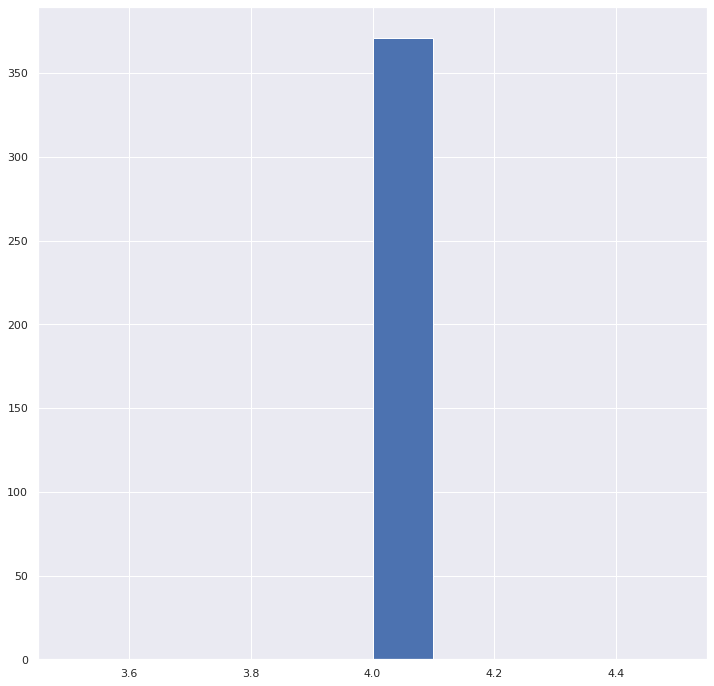

In [129]:
dv["k"].hist()

,image,at_least_24,at_least_12,at_least_10,at_least_5,k,bl,br,tl,tr
0,BennuProRes4444.mov_1frame_crf_03_height_0864,0,0,0,1,4,6,11,9,8
1,BennuProRes4444.mov_1frame_crf_06_height_0592,0,0,0,1,4,12,8,9,9
2,BennuProRes4444.mov_1frame_crf_08_height_0448,0,0,0,0,4,8,2,12,15
3,BennuProRes4444.mov_1frame_crf_13_height_0304,0,0,0,1,4,14,8,18,10
4,BennuProRes4444.mov_1frame_crf_21_height_0320,0,0,0,0,4,10,9,8,1


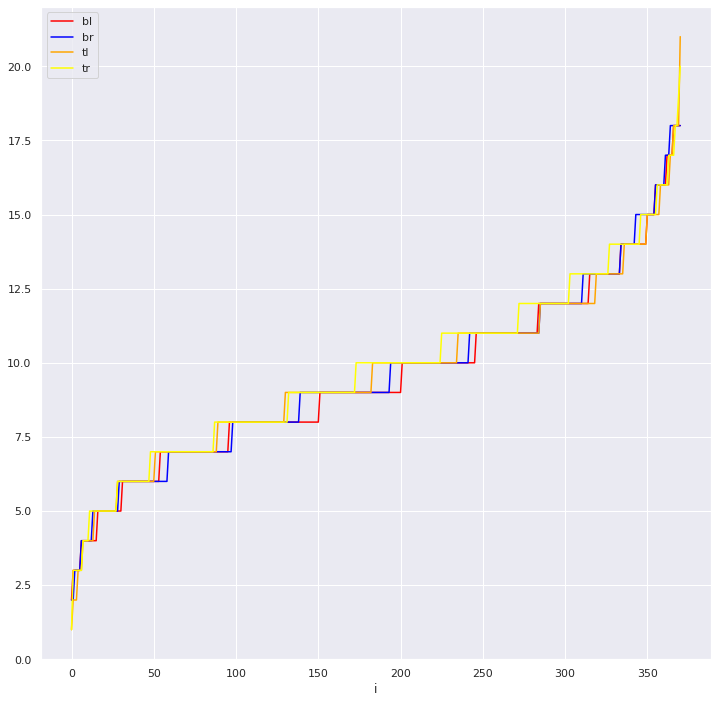

In [153]:
d(dv.head())

cmap = {
    "bl": "red", 
    "br": "blue", 
    "tl": "orange", 
    "tr": "yellow"
}
ax = None
for c in ["bl", "br", "tl", "tr"]:
    k = dv[[c, "image"]].sort_values(by=c).copy()
    k["i"] = range(len(k))
    
    ax = k.plot(x="i", y=c, kind="line", c=cmap[c], ax=ax)
    #break

,user_ID,stimuli_ID,stimuli_file,rating_type,rating,timestamp,c,image_name
1,1,688,./images/Sparks_20170214.mxf_1frame_crf_06_hei...,acr,2,2020-03-27 13:51:10 959845,1,Sparks_20170214.mxf_1frame_crf_06_height_0720
2,1,309,./images/NTIA_4K_Vignette_1_Violin-422p-8bit-6...,acr,1,2020-03-27 13:51:14 468659,1,NTIA_4K_Vignette_1_Violin-422p-8bit-60fps-4096...
3,1,152,./images/classroom.mkv_1frame_crf_12_height_03...,acr,2,2020-03-27 13:51:18 371806,1,classroom.mkv_1frame_crf_12_height_0368
4,1,1161,./images/asian_fusion_harmonic.mkv_1frame_crf_...,acr,1,2020-03-27 13:51:21 653894,1,asian_fusion_harmonic.mkv_1frame_crf_08_height...
5,1,1011,./images/monkeys_harmonic.mkv_1frame_crf_02_he...,acr,4,2020-03-27 13:51:25 718980,1,monkeys_harmonic.mkv_1frame_crf_02_height_1504


,image_name,c,i
193,american_football_harmonic.mkv_1frame_crf_13_h...,23,0
114,Netflix_DrivingPOV_4096x2160_60fps_10bit_420.y...,25,1
266,gooseberry.mkv_1frame_crf_19_height_0176,26,2
22,Campfire_3840x2160_30fps_bt709_420_videoRange_...,27,3
90,Netflix_BarScene_4096x2160_60fps_10bit_420.y4m...,28,4


Text(0, 0.5, '#ratings')

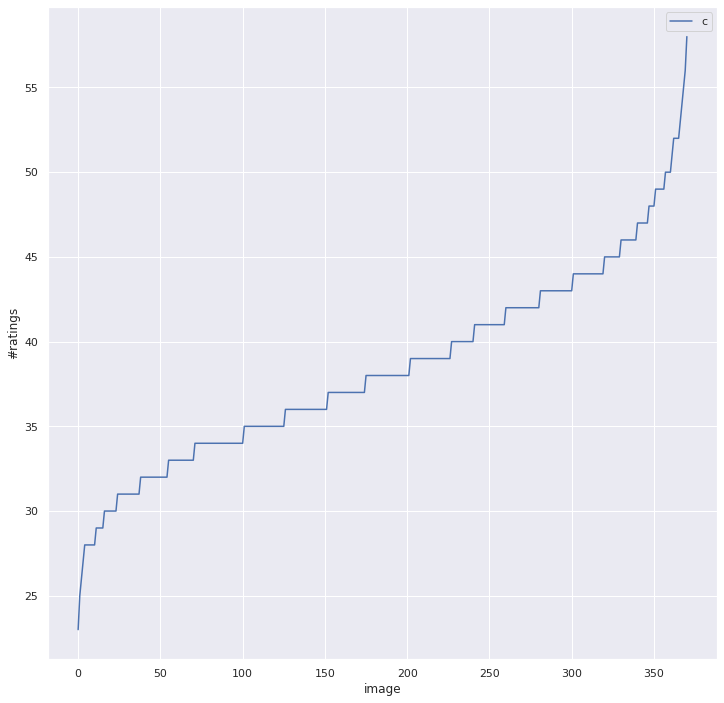

In [138]:
d(dr.head())
ddd = dr.groupby(by="image_name").count().reset_index()

ddd = ddd[["image_name", "c"]]
ddd = ddd.sort_values(by="c")
ddd["i"] = range(len(ddd))

d(ddd.head())
ax = ddd.plot(x="i", y="c", kind="line")
ax.set_xlabel("image")
ax.set_ylabel("#ratings")


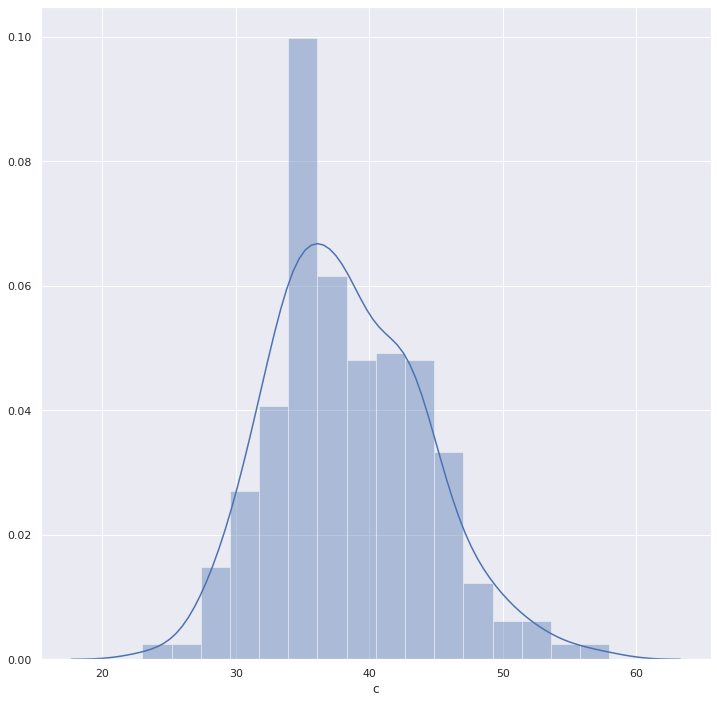

In [128]:
sns.distplot(dr.groupby("image_name").count().reset_index()["c"])

In [105]:
d(dmerged.head())
print(len(dmerged))

,image_name,mos,ci,mean_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,2.911765
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,2.552632
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,2.432432
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,1.980000
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,1.642857


371


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


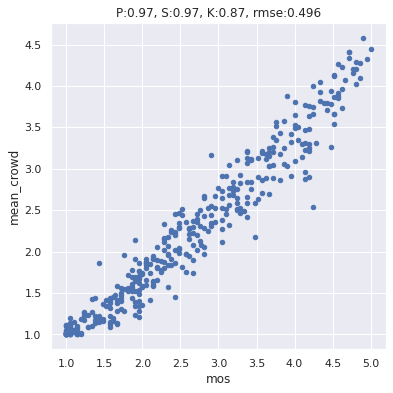

In [104]:
rmse = ((dmerged["mos"] - dmerged["mean_crowd"]) ** 2).mean() ** .5 
corr = "P:{}, S:{}, K:{}, rmse:{}".format(
    dmerged[["mos", "mean_crowd"]].corr(method="pearson")["mos"][1].round(2),
    dmerged[["mos", "mean_crowd"]].corr(method="spearman")["mos"][1].round(2),
    dmerged[["mos", "mean_crowd"]].corr(method="kendall")["mos"][1].round(2),
    rmse.round(3)
)
dmerged.plot(x="mos", y="mean_crowd", kind="scatter", figsize=(6,6), title=corr)